# COMP 562 - Machine Learning Final Project
## Plan

Our goal is to distinguish between tweets which are about real disasters and those which are about fake, metaphorical, or otherwise not real ones.
### Turning tweets into features

- Start with trigrams, can tune later
- Can consider bigrams, bag of words, or other n-grams
- Ignore location information, at least for now
- Almost all tweets have keywords, use as another feature
- Make sure to process "keyword" values, removing special characters

### Criteria for disaster
- Meant to track if tweets are referring to ongoing disasters
- Also includes historical events


### Training
- Train and validate our model on `train.csv` 
- Test by sending results to Kaggle

### Random forest
- Use Gini criterion for efficiency

### Neural networks
- Use multi-layer perceptron classifier
- Tweak alpha values

## Disaster tweet classification
### Important modules

In [1]:
import numpy as np
import pandas as pd
import string, re

### Importing data

In [2]:
train_df = pd.read_csv("disaster-tweets/data/train.csv")
test_df = pd.read_csv("disaster-tweets/data/test.csv")

### Finding all characters in dataset

In [3]:
def standardize_string(s):
    s = s.lower()
    s = re.sub("http://t\.co/\S+", "", s)
    return s

In [4]:
all_characters = set()

for tweet in train_df['text']:
    all_characters = all_characters.union(set(standardize_string(tweet)))

char_list = list(all_characters)
char_list.sort()
print(char_list)

['\n', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x89', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '«', '¬', '´', '¼', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', '÷', 'û', 'ü']


### Narrowing down characters

We decided that from these characters, we would only keep letters, numbers, and a few accented characters. We also kept '#' and '@' due to their importance on Twitter.

In [5]:
included_chars = list(string.ascii_lowercase + string.digits) + ['#', '@', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', 'ü', ' ']
print(included_chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '#', '@', 'â', 'ã', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ñ', 'ò', 'ó', 'ü', ' ']


### Removing invalid characters
- Try both with and without removing special characters
- Consider skipping data points with bad characters

In [6]:
def remove_special_characters(s):
    for c in char_list:
        if c not in included_chars:
            s = s.replace(c, "")
    return s

def format_tweet(t):
    # Makes lowercase
    formatted_tweet = t.lower()
    # Removed links
    formatted_tweet = re.sub(" http(s|)://t\.co/\S+", "", formatted_tweet)
    formatted_tweet = re.sub("http(s|)://t\.co/\S+", "", formatted_tweet)
    # Removes any special characters, other than a-z, numbers, spaces, hashtags, and @
    formatted_tweet = remove_special_characters(formatted_tweet)
    final_tweet_array = []
    
    # Removes multiple consecutive spaces
    for i, char in enumerate(formatted_tweet):
        if i == 0:
            if char != ' ':
                final_tweet_array.append(char)
                continue
        prev_char = formatted_tweet[i-1]
        if char == ' ' and prev_char == ' ':
            continue
        final_tweet_array.append(char)
    final_tweet = "".join(final_tweet_array)
    return final_tweet

In [7]:
formatted_train_tweets = []
for i, tweet in enumerate(train_df["text"]):
    formatted_train_tweets.append(format_tweet(tweet))

formatted_test_tweets = []
for tweet in test_df["text"]:
    formatted_test_tweets.append(format_tweet(tweet))
    
test_ids = test_df['id']

### Splitting tweets into bigrams

Tweets were processed into bigram representations, which includes information about two consecutive words at a time.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_train = bigram_vectorizer.fit_transform(formatted_train_tweets)
bigram_test = bigram_vectorizer.transform(formatted_test_tweets)

In [9]:
# 1-gram no string formatting
# array([0.55543823, 0.50891089, 0.54221388, 0.51913133, 0.68794326])
# 1 and 2-gram, no string formatting
# array([0.46118721, 0.45027322, 0.43412527, 0.44141069, 0.61523626])
# 1-gram basic string formatting
# array([0.57556936, 0.48219736, 0.5530303 , 0.51859504, 0.68586387])
# 1 & 2-gram, basic string formatting
# array([0.5039019 , 0.41150442, 0.41241685, 0.45823928, 0.62327416])
# bigram only, basic string formatting
# array([0.24096386, 0.25725095, 0.1682243 , 0.17475728, 0.31060606])

### Random forest classifier
#### Creating the model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_jobs=10, max_depth=None, class_weight="balanced")

#### Cross-validation

In [ ]:
rf_parameters = {
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 4),
    'n_estimators': [50, 100, 500]
}

rf_cv = GridSearchCV(rf, rf_parameters, verbose=4, n_jobs=8)
rf_cv.fit(bigram_train, train_df['target'])
print(rf_cv.best_params_)

# {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}
# {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1}

In [13]:
rf_best = RandomForestClassifier(n_jobs=10, max_depth=None, class_weight="balanced", min_samples_leaf=2, min_samples_split=4, n_estimators=500)
rf_best.fit(bigram_train, train_df['target'])

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=500, n_jobs=10)

Initially, we did cross-validation across maximum depth and number of estimators. However, these models all gave fairly poor accuracy. Instead, we switched to cross-validation across minimum samples for a split and minimum samples for a leaf. These hyperparameters allowed us to get better results. Through this second round of cross validation, we got the hyperparameters with the highest average accuracy as:

`{'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 500}`

#### Predicting test data

As the disaster tweets dataset is from a Kaggle competition, the creators chose to not make the test labels public. As such, we have the random forest model make predictions on the test data. We then submitted this data to Kaggle to get an accuracy.

In [14]:
rf_predicted_classes = rf_best.predict(bigram_test)
print(rf_predicted_classes)
rf_out_array = []
for i, pred_class in enumerate(rf_predicted_classes):
    rf_out_array.append([int(test_ids[i]), pred_class])

np.savetxt("disaster-tweets/rf-results.csv", rf_out_array, delimiter=',', fmt='%i')

[0 0 1 ... 1 1 1]


According to Kaggle, these parameters gave an F1 score of `0.74103`.

### Multilayer perceptron classifier
#### Creating the model

In [15]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(verbose=True, tol=.001)

#### Cross-validation

In [ ]:
mlpc_parameters = {
    "alpha": [.0001, .001, .01, .1]
}
mlpc_cv = GridSearchCV(mlpc, mlpc_parameters, verbose=3, n_jobs=-1)
mlpc_cv.fit(bigram_train, train_df['target'])
print(mlpc_cv.best_params_)

In [18]:
mlpc_best = MLPClassifier(verbose=True, alpha=0.0001)
mlpc_best.fit(bigram_train, train_df['target'])

Iteration 1, loss = 0.64455269
Iteration 2, loss = 0.36106995
Iteration 3, loss = 0.15817992
Iteration 4, loss = 0.09224516
Iteration 5, loss = 0.06880614
Iteration 6, loss = 0.05708070
Iteration 7, loss = 0.05171878
Iteration 8, loss = 0.04616030
Iteration 9, loss = 0.04327362
Iteration 10, loss = 0.04108837
Iteration 11, loss = 0.03849036
Iteration 12, loss = 0.03691752
Iteration 13, loss = 0.03641282
Iteration 14, loss = 0.03603631
Iteration 15, loss = 0.03538995
Iteration 16, loss = 0.03530517
Iteration 17, loss = 0.03493647
Iteration 18, loss = 0.03364997
Iteration 19, loss = 0.03393072
Iteration 20, loss = 0.03323351
Iteration 21, loss = 0.03462271
Iteration 22, loss = 0.03133024
Iteration 23, loss = 0.03159224
Iteration 24, loss = 0.03229673
Iteration 25, loss = 0.03286458
Iteration 26, loss = 0.03324324
Iteration 27, loss = 0.03158836
Iteration 28, loss = 0.03069116
Iteration 29, loss = 0.03080278
Iteration 30, loss = 0.03075475
Iteration 31, loss = 0.03056162
Iteration 32, los

MLPClassifier(verbose=True)

Through cross-validation, we determined that the best value for the regularization parameter $\alpha$ was `0.0001`.

#### Predicting test data

In [19]:
mlpc_predicted_classes = mlpc_best.predict(bigram_test)
mlpc_out_array = []
for i, pred_class in enumerate(mlpc_predicted_classes):
    mlpc_out_array.append([int(test_ids[i]), pred_class])
    
np.savetxt("disaster-tweets/mlpc-results.csv", mlpc_out_array, delimiter=',', fmt='%i')

This value gave an accuracy on the test set of `0.76156`.

#### Retrying with tri-grams

Due to undesirably low accuracy, we tried to train a multilayer perceptron classifier again, this time with tweet data represented as tri-grams rather than bi-grams.

In [ ]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_train = trigram_vectorizer.fit_transform(formatted_train_tweets)
trigram_test = trigram_vectorizer.transform(formatted_test_tweets)

mlpc_cv.fit(trigram_train, train_df['target'])
print(mlpc_cv.best_params_)

In [ ]:
mlpc_best = MLPClassifier(verbose=True, alpha=0.0001)
mlpc_best.fit(trigram_train, train_df['target'])

Unfortunately, this actually diminished the accuracy, classifying `0.70303` of the results correctly.

In [ ]:
mlpc_trigram_predicted_classes = mlpc_best.predict(trigram_test)
mlpc_trigram_out_array = []
for i, pred_class in enumerate(mlpc_trigram_predicted_classes):
    mlpc_trigram_out_array.append([int(test_ids[i]), pred_class])
    
np.savetxt("disaster-tweets/mlpc-trigam-results.csv", mlpc_trigram_out_array, delimiter=',', fmt='%i')

## Humor detection

After manual inspection and additional research on the disaster tweets dataset, we determined that the dataset itself was low quality, i.e. a number of the tweets were labeled incorrectly or did not in fact refer to a disaster of any kind. Instead, we decided to apply similar natural language techniques to another dataset. We found a dataset of 200,000 short passages of text (similar to tweets) which are labeled as either having humor or not having humor. Others' work on Kaggle gave us the impression that this dataset is high quality. We then proceeded much as before on this dataset.

### Important modules

In [20]:
import numpy as np
import pandas as pd

### Importing data

We decided to train on only 10 percent of the data, as there are 200,000 data points. Training on, for example, 60 percent of the data would take prohibitively long (more than 10 minutes for one fit). However, evaluation time is more reasonable than training time, so we can still test on the remaining 90 percent of the data.

In [21]:
from sklearn.model_selection import train_test_split

all_text = pd.read_csv("humor-dataset.csv")["text"]
all_humor = pd.read_csv("humor-dataset.csv")["humor"]

text_train, text_test, humor_train, humor_test = train_test_split(all_text, all_humor, train_size=.1)

### Making bi-grams

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_train = bigram_vectorizer.fit_transform(text_train)
bigram_test = bigram_vectorizer.transform(text_test)

### Random forest classifier
#### Making the model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_depth=None, class_weight="balanced", n_jobs=8, verbose=3)

#### Cross-validation

In [ ]:
rf_params = {
    'n_estimators': [50, 100, 500]
}

rf_cv = GridSearchCV(rf, rf_params, n_jobs=8, verbose=3)
rf_cv.fit(bigram_train, humor_train)
print(rf_cv.best_params_)

In [25]:
rf_best = RandomForestClassifier(max_depth=None, class_weight="balanced", n_jobs=8, verbose=3, n_estimators=500)
rf_best.fit(bigram_train, humor_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500building tree 2 of 500

building tree 3 of 500building tree 4 of 500building tree 5 of 500


building tree 6 of 500
building tree 7 of 500building tree 8 of 500

building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s


building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66

[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    5.0s


building tree 123 of 500
building tree 124 of 500building tree 125 of 500

building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500


[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   11.7s


building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500building tree 304 of 500

building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   20.9s finished


RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=8,
                       verbose=3)

Cross validation yielded a best n_estimators value of `500`.

#### Evaluation

The humor dataset, unlike the disaster tweets dataset, included labels for every piece of text in the dataset. As such, we are able to directly compute accuracy/F1 scores and also to plot confusion matrices.

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

def get_cm(preds):
    return confusion_matrix(humor_test, preds, labels=[False, True], normalize='all')

def plot_confusion_matrix(cm, title):
    fx = sb.heatmap(cm, annot=True, cmap='turbo')

    # labels the title and x, y axis of plot
    fx.set_title(title + '\n\n');
    fx.set_xlabel('Predicted Values')
    fx.set_ylabel('Actual Values ');

    # labels the boxes
    fx.xaxis.set_ticklabels(['False','True'])
    fx.yaxis.set_ticklabels(['False','True'])

    plt.show()

#### Confusion matrix and accuracy

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   34.2s finished


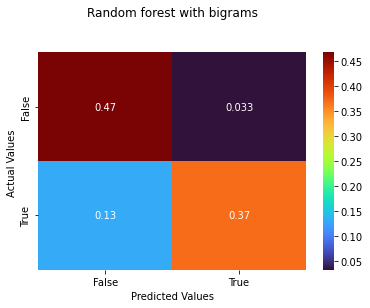

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    7.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   34.6s finished


0.8364222222222222

In [27]:
humor_preds = rf_best.predict(bigram_test)
rf_cm = get_cm(humor_preds)
plot_confusion_matrix(rf_cm, "Random forest with bigrams")
rf_best.score(bigram_test, humor_test)

A random forest classifier on the humor data was fairly effective, getting an accuracy of `0.836`.

### Multilayer perceptron classifier
#### Making the model

In [28]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(tol=.001, verbose=True)

#### Cross-validation

In [ ]:
mlpc_params = {
    "alpha": [.0001, .001, .01, .1]
}
print("Starting CV...")
mlpc_cv = GridSearchCV(mlpc, mlpc_params, verbose=3, n_jobs=8)
mlpc_cv.fit(bigram_train, humor_train)

In [29]:
mlpc_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_best.fit(bigram_train, humor_train)

Iteration 1, loss = 0.51404633
Iteration 2, loss = 0.10966864
Iteration 3, loss = 0.02148936
Iteration 4, loss = 0.00953999
Iteration 5, loss = 0.00579089
Iteration 6, loss = 0.00409206
Iteration 7, loss = 0.00316517
Iteration 8, loss = 0.00259729
Iteration 9, loss = 0.00222410
Iteration 10, loss = 0.00196409
Iteration 11, loss = 0.00177639
Iteration 12, loss = 0.00163594
Iteration 13, loss = 0.00152750
Iteration 14, loss = 0.00144242
Iteration 15, loss = 0.00137392
Iteration 16, loss = 0.00131780
Iteration 17, loss = 0.00127094
Iteration 18, loss = 0.00123111
Iteration 19, loss = 0.00119679
Iteration 20, loss = 0.00116667
Iteration 21, loss = 0.00113995
Iteration 22, loss = 0.00111578
Iteration 23, loss = 0.00109375
Iteration 24, loss = 0.00107342
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

Cross validation yielded a best regularization value of $\alpha = 0.0001$.

#### Confusion matrix and accuracy

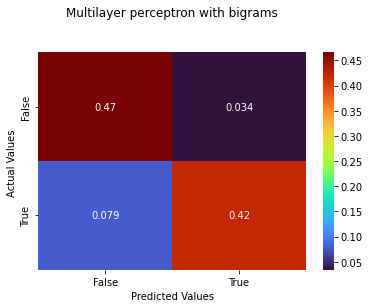

0.8868166666666667

In [30]:
humor_preds = mlpc_best.predict(bigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with bigrams")
mlpc_best.score(bigram_test, humor_test)

The multilayer perceptron classifier fared even better, getting an accuracy of `0.887` on the test data.

### Retrying with trigrams
#### Making the trigrams

In [31]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3))
trigram_train = trigram_vectorizer.fit_transform(text_train)
trigram_test = trigram_vectorizer.transform(text_test)

### Multilayer perceptron classifier with trigrams

In [32]:
mlpc_best = MLPClassifier(verbose=True, alpha=.0001)
mlpc_best.fit(trigram_train, humor_train)

Iteration 1, loss = 0.62092891
Iteration 2, loss = 0.15968523
Iteration 3, loss = 0.01999694
Iteration 4, loss = 0.00870852
Iteration 5, loss = 0.00553557
Iteration 6, loss = 0.00404487
Iteration 7, loss = 0.00321518
Iteration 8, loss = 0.00270440
Iteration 9, loss = 0.00236636
Iteration 10, loss = 0.00213134
Iteration 11, loss = 0.00196163
Iteration 12, loss = 0.00183416
Iteration 13, loss = 0.00173655
Iteration 14, loss = 0.00165933
Iteration 15, loss = 0.00159704
Iteration 16, loss = 0.00154568
Iteration 17, loss = 0.00150269
Iteration 18, loss = 0.00146556
Iteration 19, loss = 0.00143334
Iteration 20, loss = 0.00140462
Iteration 21, loss = 0.00137872
Iteration 22, loss = 0.00135494
Iteration 23, loss = 0.00133280
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(verbose=True)

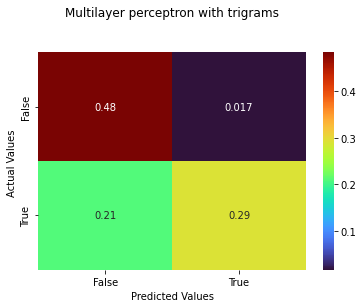

0.7737666666666667

In [33]:
humor_preds = mlpc_best.predict(trigram_test)
mlpc_cm = get_cm(humor_preds)
plot_confusion_matrix(mlpc_cm, "Multilayer perceptron with trigrams")
mlpc_best.score(trigram_test, humor_test)

Interestingly, the MLP classifier performed significantly worse when trained on trigrams, giving an accuracy of `0.774`. Note, however, that it's performance on fake disaster tweets was excellent, while its performance on true disaster tweets was only slightly better than chance.